In [1]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\ANJA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

<h1 style="color: #ab5bb0">Ucitavanje podataka: - STARO</h1>

In [3]:
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

train_val_data_dir = r'..\..\images\train'
#train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
test_data_dir = r'..\..\images\test'
#test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<h1>NOVO UCITAVANJE PODATAKA SA OVERSAMPLINGOM ZA DISGUST</h1>

In [2]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np
import os
import random

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# --- Parametri ---
train_val_data_dir = r'..\..\images\train'
img_height = 48
img_width = 48
batch_size = 128
target_class = 'disgust'
target_count = 4000

# --- Učitaj sve slike u memoriju (kao test DS, bez split) ---
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinačne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# --- Razdvoji slike po klasama ---
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# --- Oversampling ciljne klase ---
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# --- Spoji sve klase ---
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# --- Permutacija da batch-evi budu mešani ---
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# --- Stratified split 80/20 po klasama ---
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# --- Permutacija nakon split-a ---
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# --- Kreiraj batch-eve kao image_dataset_from_directory ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  # shuffle pre batch-a
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [3]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [4]:
print(train_ds.class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# test DS
batch_size = 128
test_data_dir = r'..\..\images\test'
#test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        
        - training 28821
        
        - validation (test kod nas) 7066

In [6]:
def show_first_images_by_category_grayscale(dataset): 
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

In [7]:
# Metoda koja prikazuje po jednu sliku iz svake kategorije - rgb 
def show_first_images_by_category_rgb(dataset):   
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image) 
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

<h3 style="color: #ab5bb0">Prebrojavanje slika po kategorijama:</h3>

In [8]:
def count_labels(dataset):
    counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
    return counts



print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))


Train dataset: {'angry': 3194, 'disgust': 3200, 'fear': 3282, 'happy': 5731, 'neutral': 3985, 'sad': 3950, 'surprise': 2564}
Validation dataset: {'angry': 799, 'disgust': 800, 'fear': 821, 'happy': 1433, 'neutral': 997, 'sad': 988, 'surprise': 641}
Test dataset: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - nisu jos normalizovane niti konv. u rgb</h3>

In [9]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

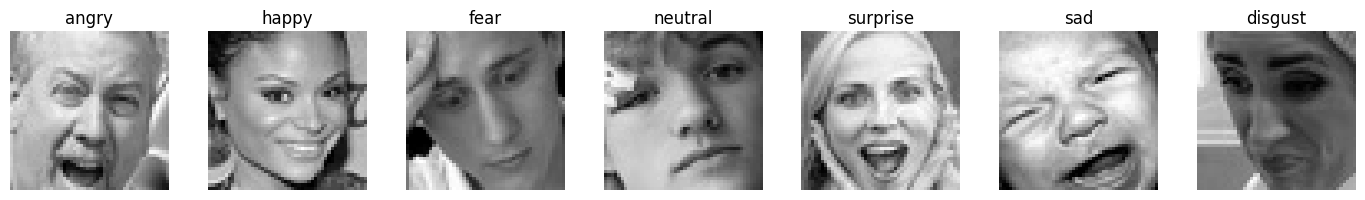

In [10]:
show_first_images_by_category_grayscale(train_ds)

<h4>Normalizacija:</h4>

In [11]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

In [12]:
for x, y in train_ds.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 1)

(128, 48, 48, 1)


Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


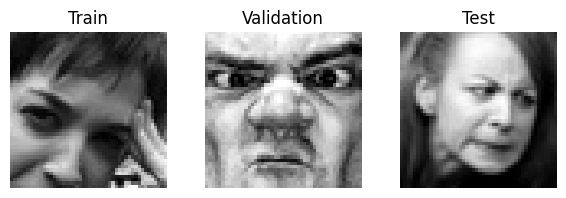

In [13]:
# Metoda koja prikazuje po 1 sliku iz train test i validation skupova
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikaz slika u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)

<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, nisu konv. u rgb</h3>

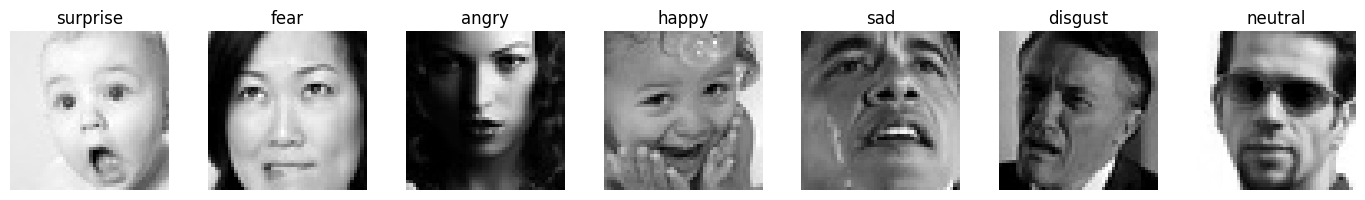

In [14]:
show_first_images_by_category_grayscale(train_ds)

Augmentacija train seta:

In [15]:
# Data augmentation - pozvati u modelu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2)
])

<h4>GRAYSLACE TO RGB:</h4>

In [16]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

for x, y in train_ds_rgb.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 3)


(128, 48, 48, 3)


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, konv. u rgb</h3>

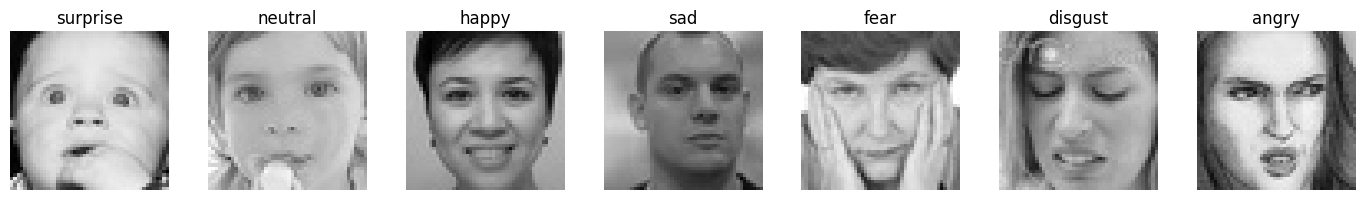

In [17]:
show_first_images_by_category_rgb(train_ds_rgb)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Metoda koja prikazuje sliku u realnoj velicini (za poredjenje prilikom resize-a)
def show_first_image_real_size(dataset, dpi=100):
    # 1. batch
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break
    
    # 1. slika
    image = images[0]
    
    h, w = image.shape[:2]

    fig_width = w / dpi
    fig_height = h / dpi

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    plt.show()


In [19]:
def resize_images(x, y, h=128, w=128):
    #x = tf.image.resize(x, [h, w], method='nearest') - jako istice piksele
    x = tf.image.resize(x, [h, w], method=tf.image.ResizeMethod.BILINEAR)

    return x, y

<h1 style="color: #16537e">VGGNET 19</h1> - 3 puta sporiji od inceptiona

In [76]:
train_ds_rgb_1 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))
val_ds_rgb_1   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))
test_ds_rgb_1  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))

In [48]:
for x, y in train_ds_rgb_1.take(1):
    print(x.shape) 

(128, 96, 96, 3)


Dimenzije slike: (48, 48, 3)


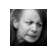

Dimenzije slike: (96, 96, 3)


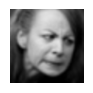

In [49]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_1.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_1)

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametri
img_height = 96
img_width = 96
num_classes = 7
batch_size = 128
learning_rate = 5e-3 #spor model, krecem sa vecom LR
epochs = 80

# Data augmentation - u radu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


# Build VGG19 model
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in vgg_base.layers:
    layer.trainable = False

for i, layer in enumerate(vgg_base.layers):
    print(i, layer.name, layer.__class__.__name__, layer.trainable)


inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
#jaci dense sloj
x = layers.Dense(128, activation='relu')(x) 
#x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x) #rad
x = layers.Dropout(0.2)(x) #u radu 0.5
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

0 input_layer_19 InputLayer False
1 block1_conv1 Conv2D False
2 block1_conv2 Conv2D False
3 block1_pool MaxPooling2D False
4 block2_conv1 Conv2D False
5 block2_conv2 Conv2D False
6 block2_pool MaxPooling2D False
7 block3_conv1 Conv2D False
8 block3_conv2 Conv2D False
9 block3_conv3 Conv2D False
10 block3_conv4 Conv2D False
11 block3_pool MaxPooling2D False
12 block4_conv1 Conv2D False
13 block4_conv2 Conv2D False
14 block4_conv3 Conv2D False
15 block4_conv4 Conv2D False
16 block4_pool MaxPooling2D False
17 block5_conv1 Conv2D False
18 block5_conv2 Conv2D False
19 block5_conv3 Conv2D False
20 block5_conv4 Conv2D False
21 block5_pool MaxPooling2D False
Epoch 1/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 1721s 8s/step - accuracy: 0.1935 - auc: 0.5639 - loss: 1.9756 - precision: 0.2541 - recall: 0.0042 - val_accuracy: 0.2534 - val_auc: 0.6341 - val_loss: 1.8791 - val_precision: 0.5633 - val_recall: 0.0213 - learning_rate: 0.0050
Epoch 2/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 1765s 8s/step - accuracy: 0.2208 

In [51]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # one-vs-rest

# Classification report per class 
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("vgg19_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'vgg19_full_report.txt'")


Sve metrike i report su sačuvani u 'vgg19_full_report.txt'


In [52]:
with open("vgg19_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.7388287782669067, 0.3188508450984955, 0.6834170818328857, 0.03849419578909874, 0.6998756527900696]

=== Global metrics ===
Accuracy: 0.3189
Macro Precision: 0.2767
Weighted Precision: 0.3141
Macro Recall: 0.3076
Weighted Recall: 0.3189
Macro F1: 0.2309
Weighted F1: 0.2712
AUC (OVR): 0.6893

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.1930    0.0458    0.0741       960
           1     0.0556    0.5045    0.1001       111
           2     0.2936    0.0314    0.0568      1018
           3     0.3874    0.7288    0.5059      1825
           4     0.3062    0.1299    0.1824      1216
           5     0.2650    0.1905    0.2217      1139
           6     0.4365    0.5220    0.4754       797

    accuracy                         0.3189      7066
   macro avg     0.2767    0.3076    0.2309      7066
weighted avg     0.3141    0.3189    0.2712      7066

In [53]:
model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,225,111 (77.15 MB)

 Trainable params: 66,823 (261.03 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

 Optimizer params: 133,648 (522.07 KB)

In [54]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

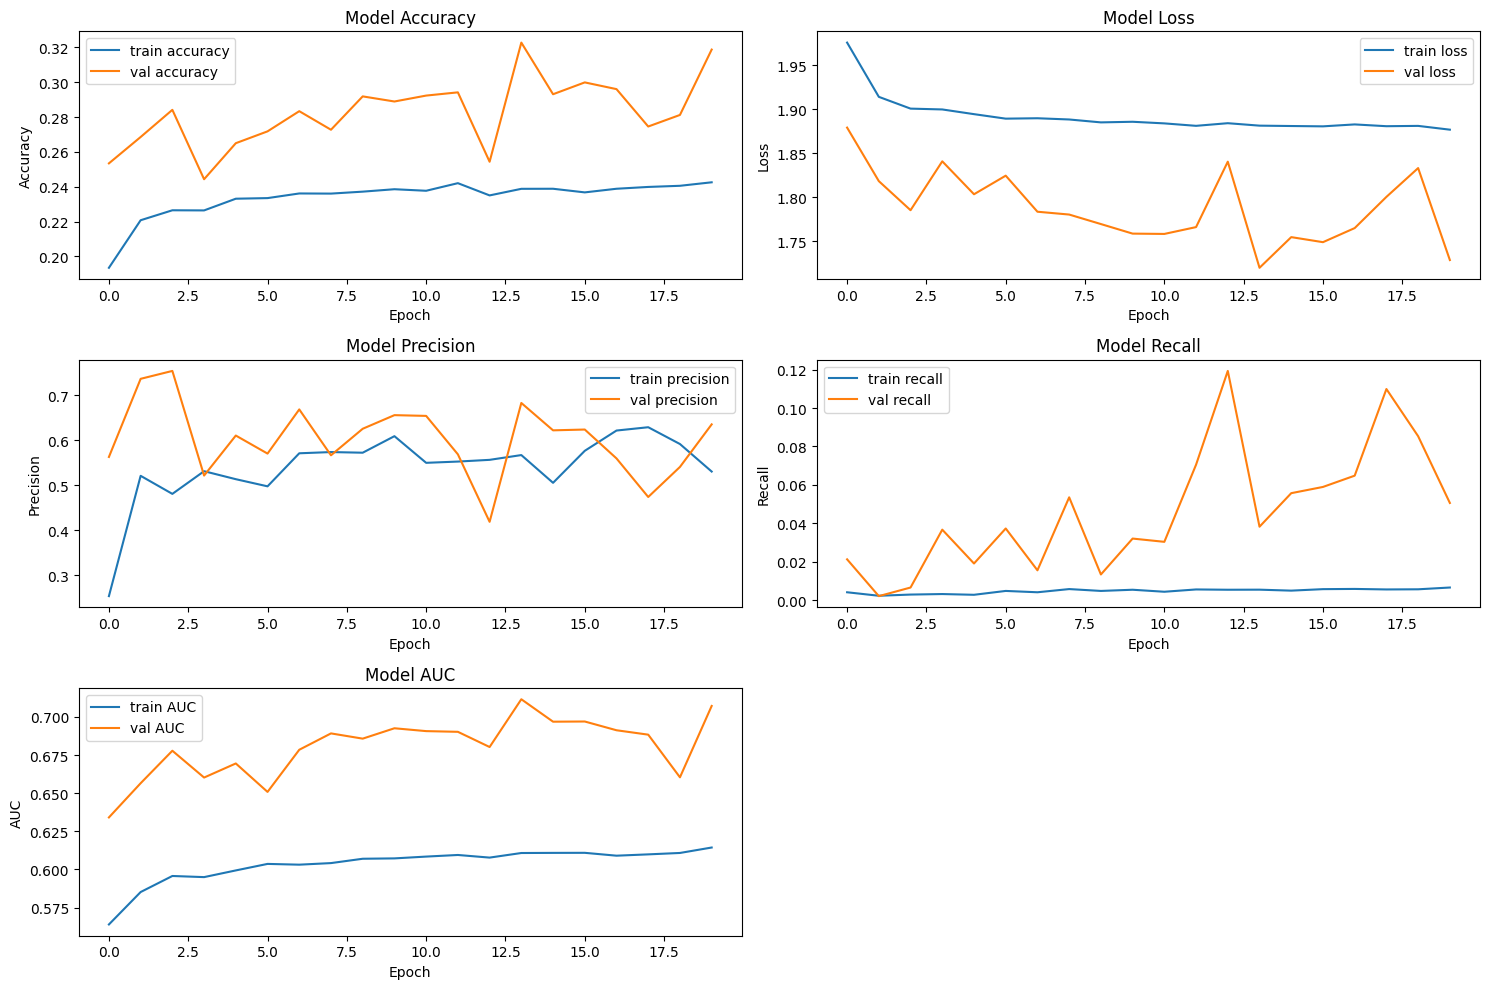

In [55]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


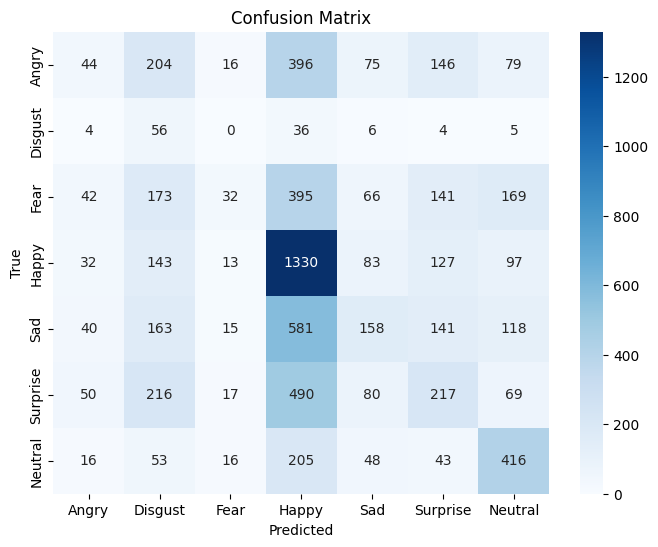

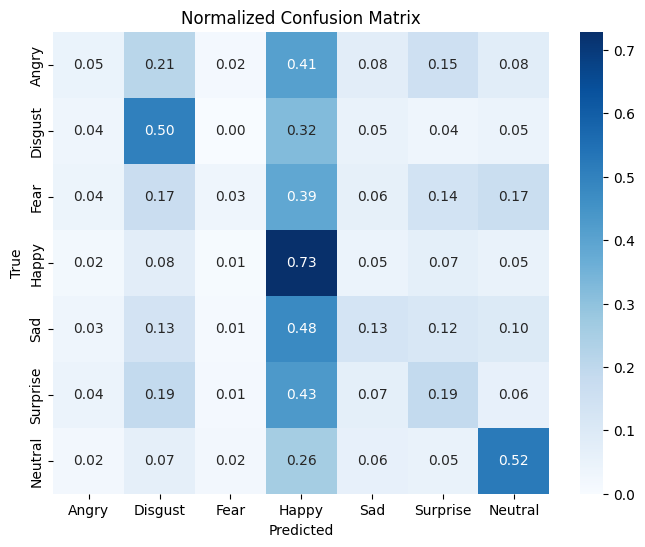

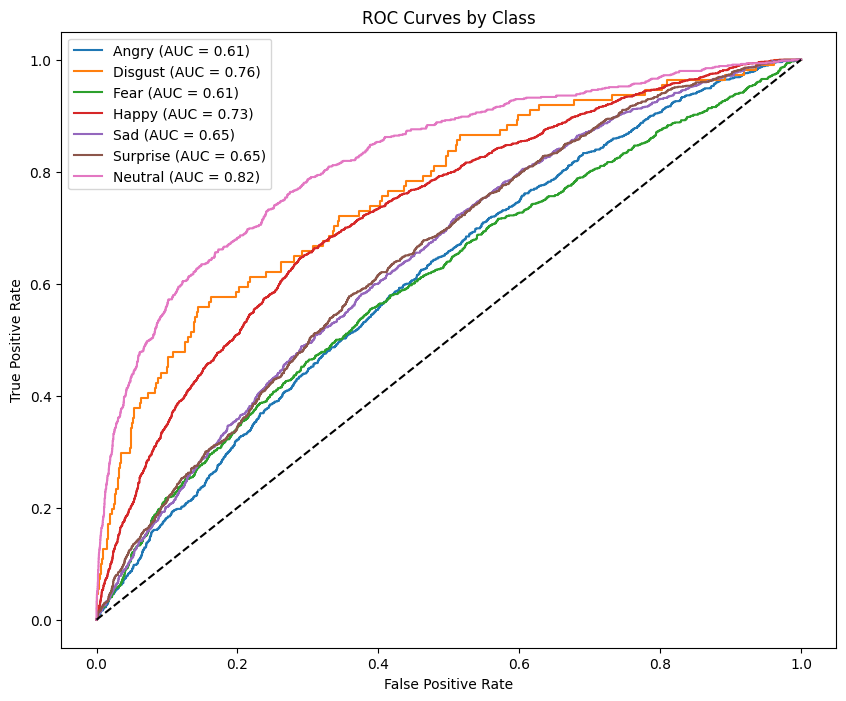

In [56]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




<h2>FINE-TUNING VGGNET 19:</h2>

In [57]:
# Fine-tuning setup
fine_tune_epochs = 25  

fine_tune_at = 17  # block5_conv1

for layer in vgg_base.layers[:fine_tune_at]:
    layer.trainable = False

for layer in vgg_base.layers[fine_tune_at:]:
    # Otkljucam samo Conv2D i Dense slojeve
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
        layer.trainable = True
    else:
        layer.trainable = False
            

# Optimizer za fine-tuning (manji LR)
fine_tune_optimizer = optimizers.Adam(learning_rate=1e-4, amsgrad=True)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             metrics.Precision(name='precision'),
             metrics.Recall(name='recall'),
             metrics.AUC(name='auc')]
)

# Nastavi treniranje (fine-tune)
history_fine = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluacija nakon fine-tuninga
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# Predikcija i metrike
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)



Epoch 20/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 1916s 9s/step - accuracy: 0.2289 - auc: 0.5944 - loss: 1.9035 - precision: 0.5043 - recall: 0.0045 - val_accuracy: 0.2689 - val_auc: 0.6436 - val_loss: 1.8685 - val_precision: 0.6499 - val_recall: 0.0358 - learning_rate: 1.0000e-04
Epoch 21/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 1929s 10s/step - accuracy: 0.2487 - auc: 0.6178 - loss: 1.8677 - precision: 0.6145 - recall: 0.0085 - val_accuracy: 0.3275 - val_auc: 0.7116 - val_loss: 1.7609 - val_precision: 0.7987 - val_recall: 0.0190 - learning_rate: 1.0000e-04
Epoch 22/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 2018s 10s/step - accuracy: 0.2584 - auc: 0.6315 - loss: 1.8482 - precision: 0.6645 - recall: 0.0193 - val_accuracy: 0.2642 - val_auc: 0.6386 - val_loss: 1.8363 - val_precision: 0.6701 - val_recall: 0.0502 - learning_rate: 1.0000e-04
Epoch 23/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 2006s 10s/step - accuracy: 0.2685 - auc: 0.6431 - loss: 1.8299 - precision: 0.6677 - recall: 0.0248 - val_accuracy: 0.3340 - val_auc: 

In [58]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("vgg19_finetune_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'vgg19_finetune_full_report.txt'")


Sve metrike i report su sačuvani u 'vgg19_finetune_full_report.txt'


In [59]:
with open("vgg19_finetune_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.1402033567428589, 0.5673648715019226, 0.7287555932998657, 0.3920181095600128, 0.8898312449455261]

=== Global metrics ===
Accuracy: 0.5674
Macro Precision: 0.5210
Weighted Precision: 0.5702
Macro Recall: 0.5515
Weighted Recall: 0.5674
Macro F1: 0.5205
Weighted F1: 0.5598
AUC (OVR): 0.8675

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4901    0.4115    0.4473       960
           1     0.3060    0.6396    0.4140       111
           2     0.4550    0.2583    0.3296      1018
           3     0.7850    0.8044    0.7946      1825
           4     0.4531    0.6637    0.5385      1216
           5     0.4521    0.4144    0.4324      1139
           6     0.7060    0.6688    0.6869       797

    accuracy                         0.5674      7066
   macro avg     0.5210    0.5515    0.5205      7066
weighted avg     0.5702    0.5674    0.5598      7066


In [60]:
model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,609,630 (185.43 MB)

 Trainable params: 9,506,055 (36.26 MB)

 Non-trainable params: 10,585,408 (40.38 MB)

 Optimizer params: 28,518,167 (108.79 MB)

In [61]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

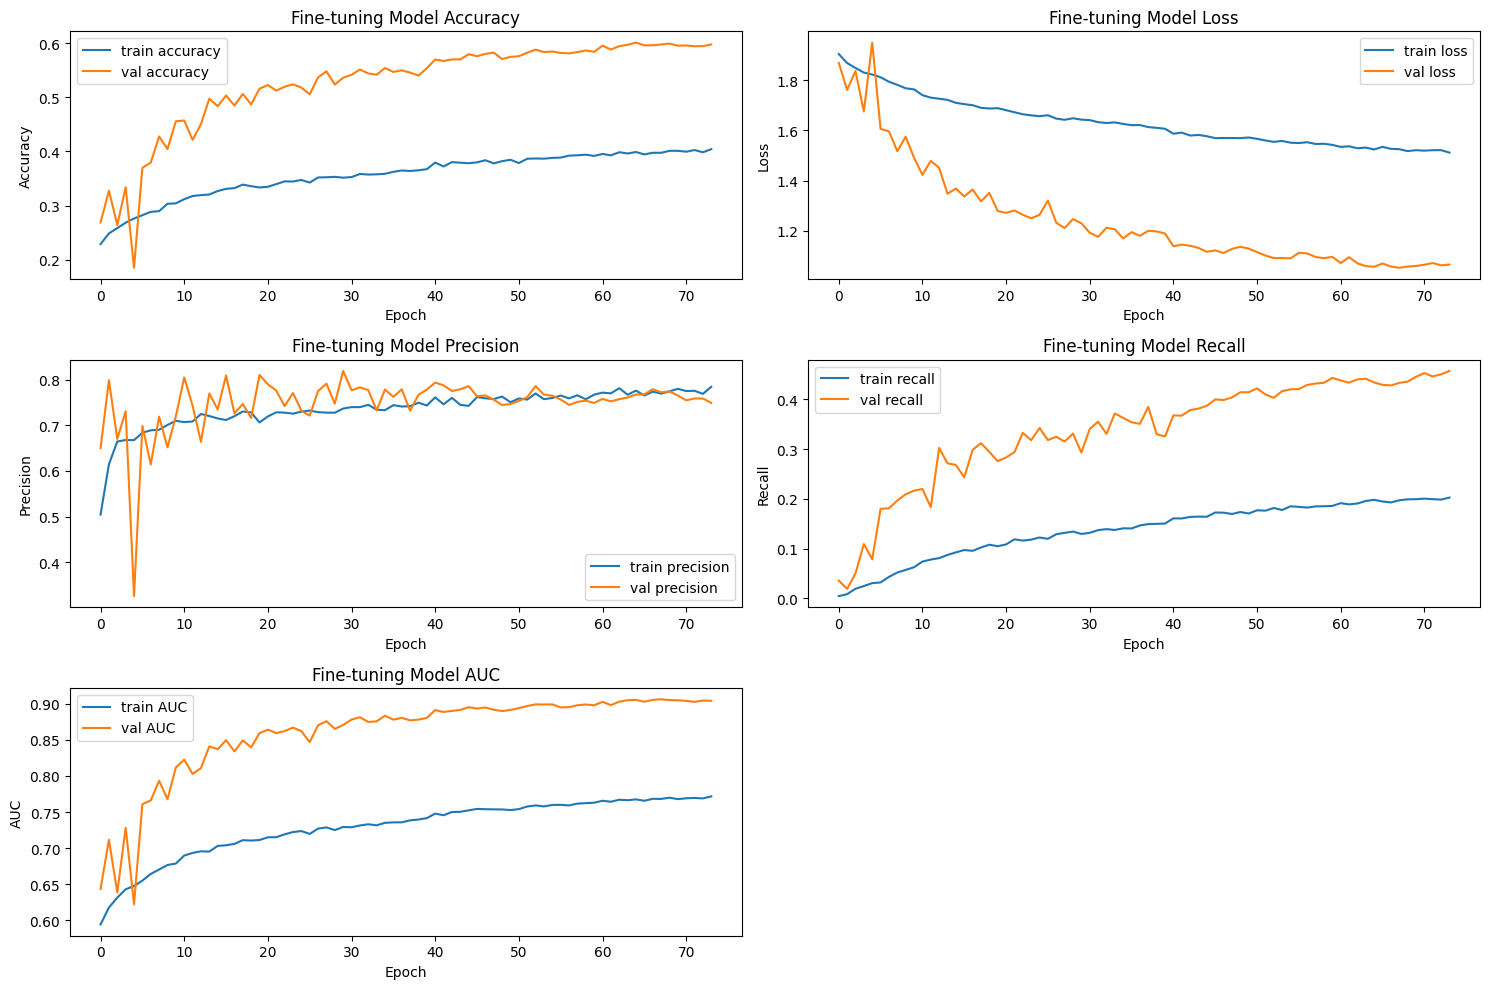

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.title('Fine-tuning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history_fine.history['precision'], label='train precision')
plt.plot(history_fine.history['val_precision'], label='val precision')
plt.title('Fine-tuning Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history_fine.history['recall'], label='train recall')
plt.plot(history_fine.history['val_recall'], label='val recall')
plt.title('Fine-tuning Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history_fine.history['auc'], label='train AUC')
plt.plot(history_fine.history['val_auc'], label='val AUC')
plt.title('Fine-tuning Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


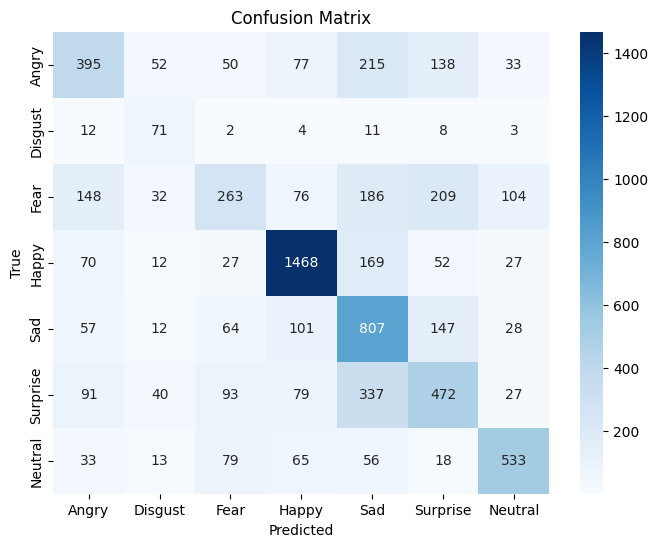

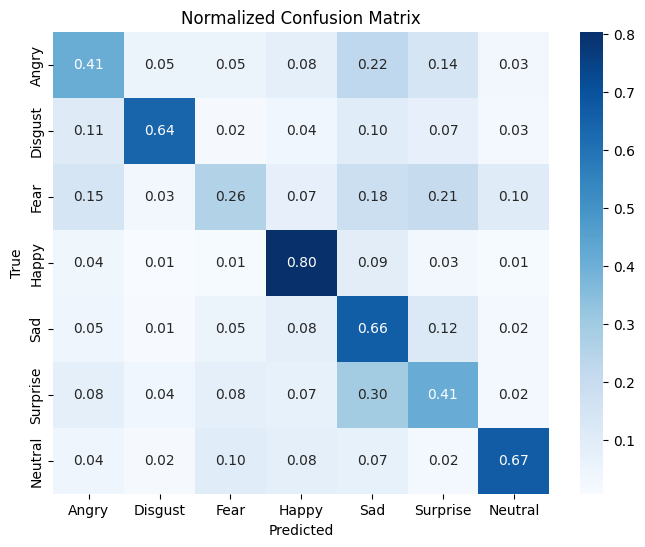

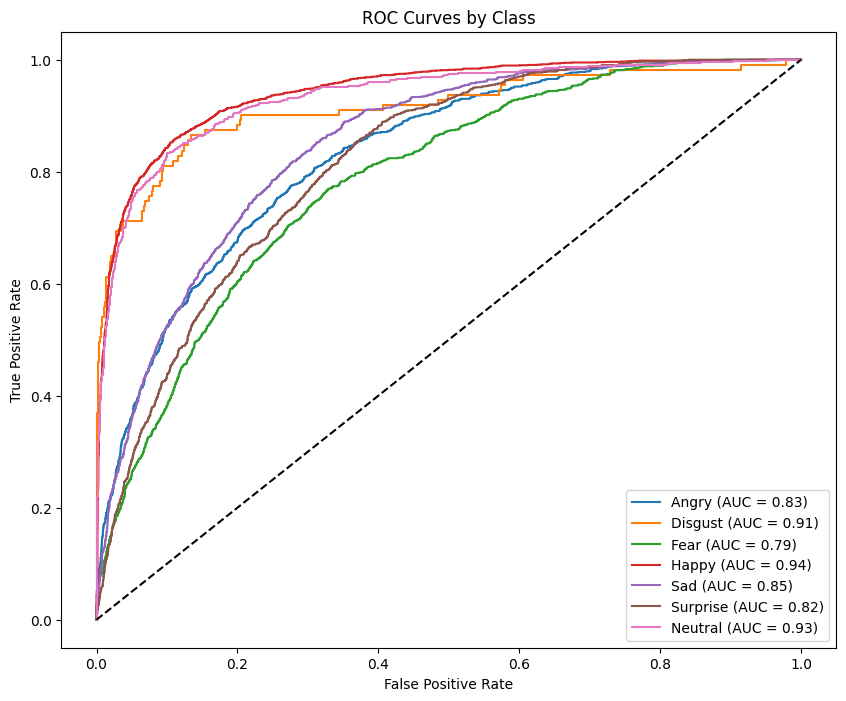

In [63]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [64]:
best_model.summary()


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,609,630 (185.43 MB)

 Trainable params: 9,506,055 (36.26 MB)

 Non-trainable params: 10,585,408 (40.38 MB)

 Optimizer params: 28,518,167 (108.79 MB)

In [5]:
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
for i, layer in enumerate(best_model.get_layer("vgg19").layers):
    print(i, layer.name, layer.__class__.__name__, layer.trainable)

0 input_layer_19 InputLayer True
1 block1_conv1 Conv2D False
2 block1_conv2 Conv2D False
3 block1_pool MaxPooling2D False
4 block2_conv1 Conv2D False
5 block2_conv2 Conv2D False
6 block2_pool MaxPooling2D False
7 block3_conv1 Conv2D False
8 block3_conv2 Conv2D False
9 block3_conv3 Conv2D False
10 block3_conv4 Conv2D False
11 block3_pool MaxPooling2D False
12 block4_conv1 Conv2D False
13 block4_conv2 Conv2D False
14 block4_conv3 Conv2D False
15 block4_conv4 Conv2D False
16 block4_pool MaxPooling2D False
17 block5_conv1 Conv2D True
18 block5_conv2 Conv2D True
19 block5_conv3 Conv2D True
20 block5_conv4 Conv2D True
21 block5_pool MaxPooling2D False


<h3>ADDITIONAL FINE TUNING VGGNET 19</h3>

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report

# --- Učitavanje prethodno treniranog modela ---
best_model = tf.keras.models.load_model("best_vgg19_model.keras")

# --- Parametri ---
fine_tune_epochs = 20
batch_size = 128

# --- Postavljanje slojeva za fine-tuning ---
vgg = best_model.get_layer("vgg19")
fine_tune_at = 12  # block4_conv1

for layer in vgg.layers[:fine_tune_at]:
    layer.trainable = False
for layer in vgg.layers[fine_tune_at:]:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
        layer.trainable = True
    else:
        layer.trainable = False

# --- Optimizator i callback-ovi ---
fine_tune_optimizer = optimizers.Adam(learning_rate=1e-5, amsgrad=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_vgg19_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

best_model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# --- Definisanje Augmentacije ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

# --- Augmentacija sa oversamplingom za retke klase ---
rare_class_repeat = {
    'Fear': 3,       # Povećano ponavljanje za 'Fear'
    'Surprise': 2,   
    'Angry': 2,      
}

train_class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Indeksi retkih klasa
all_rare_indices = [train_class_names.index(cls) for cls in rare_class_repeat.keys()]
# Pretvori listu u tensor
rare_indices_tensor = tf.constant(all_rare_indices, dtype=tf.int64)

# Unbatch train_ds (pretpostavljamo da je train_ds_rgb_1 dataset)
train_ds_unbatched = train_ds_rgb_1.unbatch() 

# Izdvajanje retkih klasa i augmentacija
rare_datasets = []

for rare_class, repeat_num in rare_class_repeat.items():
    rare_idx = train_class_names.index(rare_class)
    
    rare_ds = train_ds_unbatched.filter(lambda x, y: tf.argmax(y) == rare_idx)
    rare_ds_aug = rare_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE).repeat(repeat_num - 1)
    rare_datasets.append(rare_ds_aug)

# Izdvajanje ostalih klasa (koje nisu retke) - ISPRAVLJENO
def is_not_rare_tf(x, y):
    current_class_idx = tf.argmax(y)
    is_rare = tf.reduce_any(tf.equal(current_class_idx, rare_indices_tensor))
    return tf.logical_not(is_rare)

common_ds = train_ds_unbatched.filter(is_not_rare_tf)


# Spajanje svih datasetova u jedan izbalansirani skup
# Originalni dataset + svi augmentovani setovi
train_ds_balanced = train_ds_unbatched
for ds in rare_datasets:
    train_ds_balanced = train_ds_balanced.concatenate(ds)

# Mešanje celokupnog skupa podataka (svi originalni i augmentovani primeri)
# Povećajte buffer_size po potrebi, u zavisnosti od memorije
train_ds_balanced = train_ds_balanced.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
train_ds_balanced = train_ds_balanced.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Priprema validacionog skupa ---
val_ds_for_fit = val_ds_rgb_1.repeat()

# --- Izračunavanje steps_per_epoch ---
# Neophodno je ponovo prebrojati uzorke, jer je `concatenate` izmenio kardinalnost
print("Brojanje uzoraka za steps_per_epoch...")
total_train_samples = 0
for _ in train_ds_balanced:
    total_train_samples += batch_size

steps_per_epoch = total_train_samples // batch_size
print(f"Izračunati steps_per_epoch: {steps_per_epoch}")


# Fine-tuning
history_fine = best_model.fit(
    train_ds_balanced,
    validation_data=val_ds_for_fit,
    epochs=fine_tune_epochs,
    steps_per_epoch=steps_per_epoch,
    initial_epoch=0,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluacija
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# Predikcija i metrike
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0, target_names=train_class_names))


Brojanje uzoraka za steps_per_epoch...
Izračunati steps_per_epoch: 310
Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3653 - auc: 0.7440 - loss: 1.5877 - precision: 0.7270 - recall: 0.1730  

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("vgg19_finetune_full_additional_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'vgg19_finetune_full_additional_report.txt'")


In [ ]:
with open("vgg19_finetune_full_additional_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.title('Fine-tuning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history_fine.history['precision'], label='train precision')
plt.plot(history_fine.history['val_precision'], label='val precision')
plt.title('Fine-tuning Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history_fine.history['recall'], label='train recall')
plt.plot(history_fine.history['val_recall'], label='val recall')
plt.title('Fine-tuning Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history_fine.history['auc'], label='train AUC')
plt.plot(history_fine.history['val_auc'], label='val AUC')
plt.title('Fine-tuning Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [ ]:
best_model.summary()

In [ ]:
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
for i, layer in enumerate(best_model.get_layer("vgg19").layers):
    print(i, layer.name, layer.__class__.__name__, layer.trainable)

<h3>Prikaz na prvim slikama test seta - VGGNET 19:</h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

best_model = tf.keras.models.load_model('best_vgg19_model.keras')

# batch size = 128
for X_batch, y_batch in test_ds_rgb_1.take(1):
    X_test = X_batch.numpy()
    y_test = y_batch.numpy()

# Vizualizacija prvih 36 predikcija
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i]  # (48,48,3)
    
    # Predikcija
    p_dist = best_model.predict(img[np.newaxis, ...])
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img)  # RGB prikaz
    plt.title(f'{emotions[np.argmax(y_test[i])]} - ({emotions[k]} - {p:.4f})', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


<h1 style="color: #16537e">GOOGLENET INCEPTION V3</h1>

In [48]:
train_ds_rgb_2 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
val_ds_rgb_2   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
test_ds_rgb_2  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))

In [49]:
for x, y in train_ds_rgb_2.take(1):
    print(x.shape) 

(128, 130, 130, 3)


Dimenzije slike: (48, 48, 3)


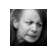

Dimenzije slike: (130, 130, 3)


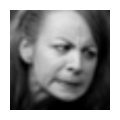

In [50]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_2.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_2)

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, f1_score

# Parametri
img_height = 130
img_width = 130
num_classes = 7
batch_size = 128
learning_rate = 5e-4 #u radu je 1e-3
epochs = 80

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.15)
])

# Build InceptionV3 model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in inception_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = inception_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x) 
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_inception_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 661s 3s/step - accuracy: 0.2773 - auc: 0.6576 - loss: 1.9186 - precision: 0.3915 - recall: 0.0728 - val_accuracy: 0.3337 - val_auc: 0.7155 - val_loss: 1.7238 - val_precision: 0.5810 - val_recall: 0.0681 - learning_rate: 0.0010
Epoch 2/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.3289 - auc: 0.7089 - loss: 1.7442 - precision: 0.5186 - recall: 0.0845 - val_accuracy: 0.3689 - val_auc: 0.7482 - val_loss: 1.6374 - val_precision: 0.6256 - val_recall: 0.1057 - learning_rate: 0.0010
Epoch 3/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.3331 - auc: 0.7192 - loss: 1.7153 - precision: 0.5423 - recall: 0.0821 - val_accuracy: 0.3527 - val_auc: 0.7452 - val_loss: 1.6483 - val_precision: 0.5884 - val_recall: 0.1377 - learning_rate: 0.0010
Epoch 4/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.3483 - auc: 0.7332 - loss: 1.6798 - precision: 0.5772 - recall: 0.0943 - val_accuracy: 0.3751 - val_auc: 0.7535 - val_loss: 1.6201 -

In [52]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# --- Macro and Weighted metrics ---
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# --- Classification report per class ---
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# --- Save everything to file ---
with open("inception_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'inception_full_report.txt'")


Sve metrike i report su sačuvani u 'inception_full_report.txt'


In [64]:
with open("inception_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.4711296558380127, 0.43999433517456055, 0.6456470489501953, 0.19416926801204681, 0.80738765001297]

=== Global metrics ===
Accuracy: 0.4400
Macro Precision: 0.3968
Weighted Precision: 0.4457
Macro Recall: 0.4330
Weighted Recall: 0.4400
Macro F1: 0.3759
Weighted F1: 0.4232
AUC (OVR): 0.7907

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4149    0.2208    0.2882       960
           1     0.1196    0.6036    0.1997       111
           2     0.3902    0.1326    0.1979      1018
           3     0.5489    0.7079    0.6183      1825
           4     0.3946    0.4836    0.4346      1216
           5     0.3916    0.3266    0.3562      1139
           6     0.5181    0.5558    0.5363       797

    accuracy                         0.4400      7066
   macro avg     0.3968    0.4330    0.3759      7066
weighted avg     0.4457    0.4400    0.4232      7066


In [53]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_286              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_287              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,643,895 (86.38 MB)

 Trainable params: 280,199 (1.07 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

 Optimizer params: 560,400 (2.14 MB)

In [54]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

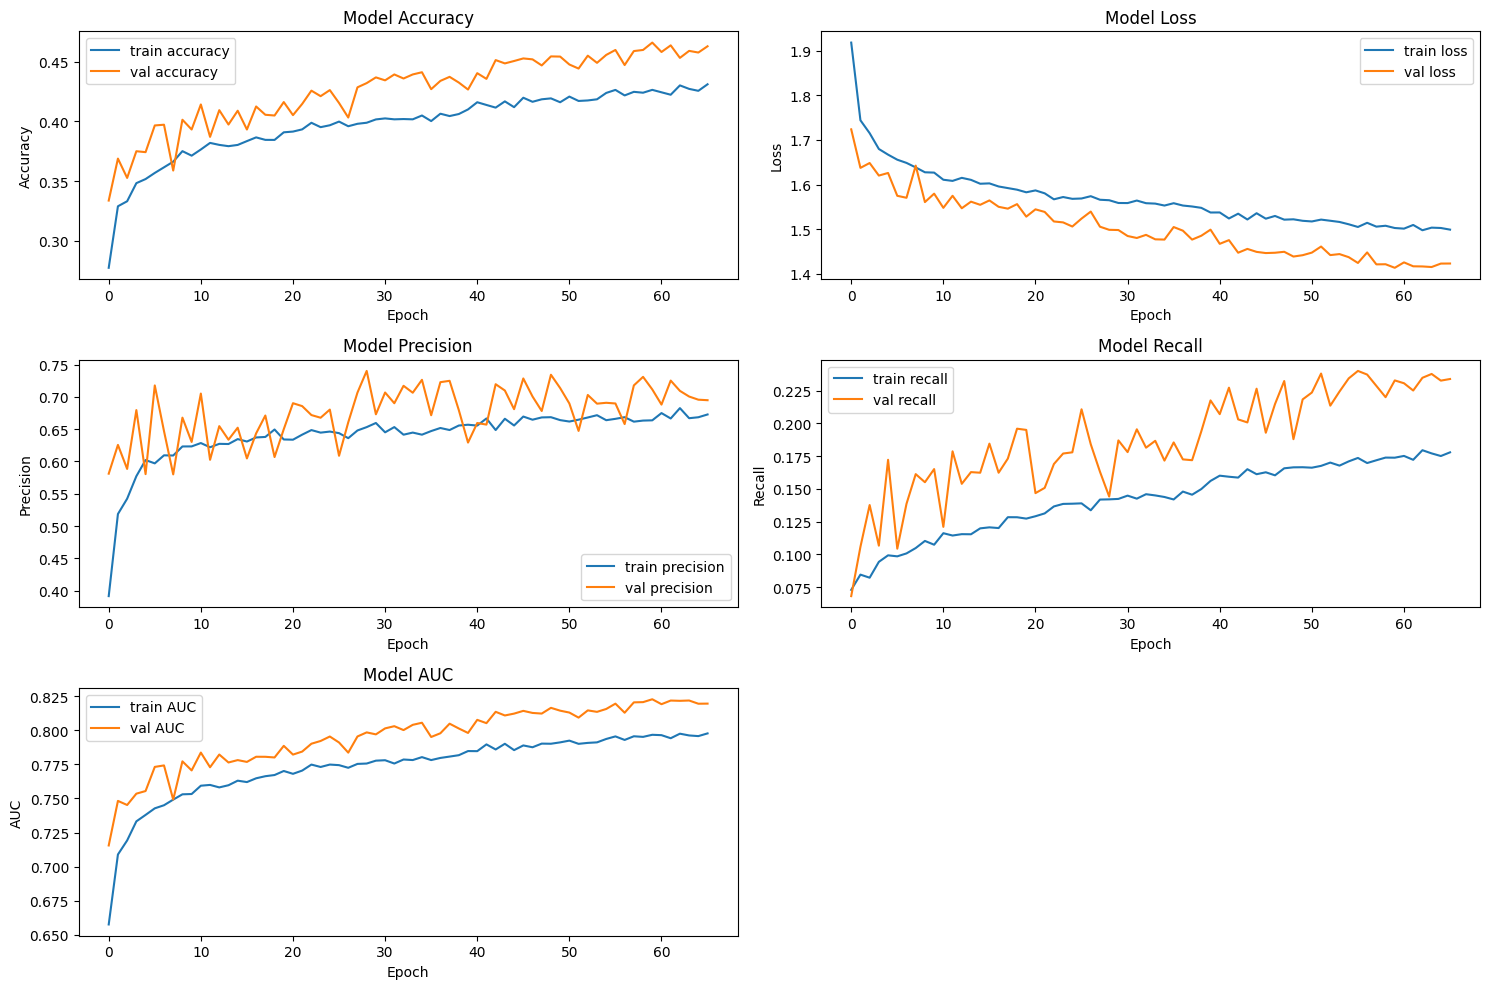

In [55]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


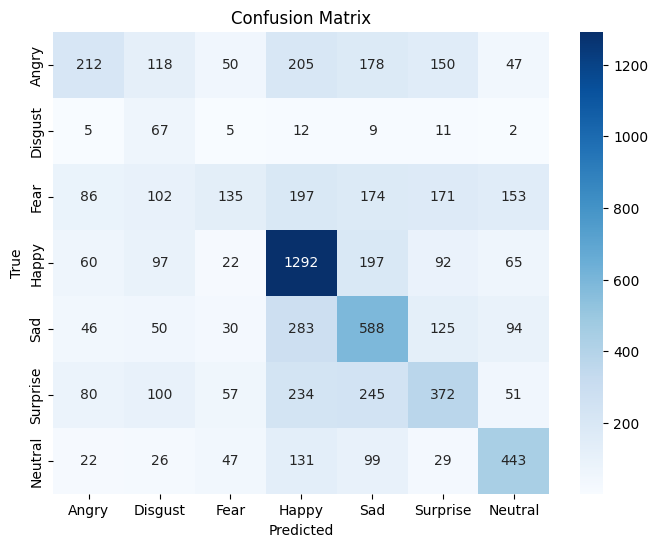

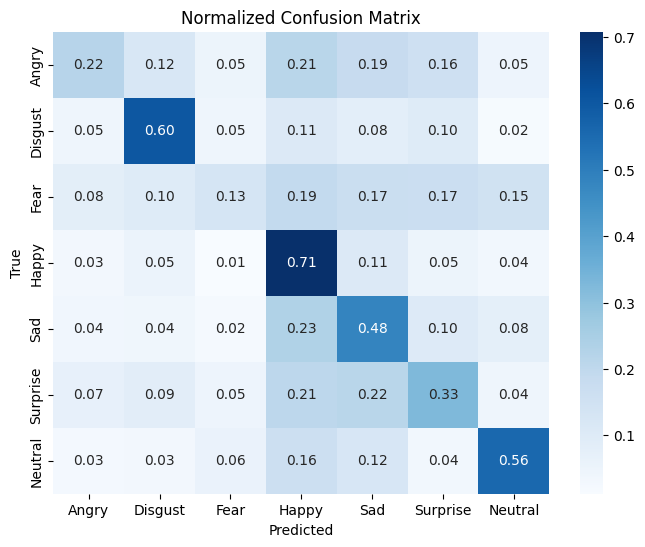

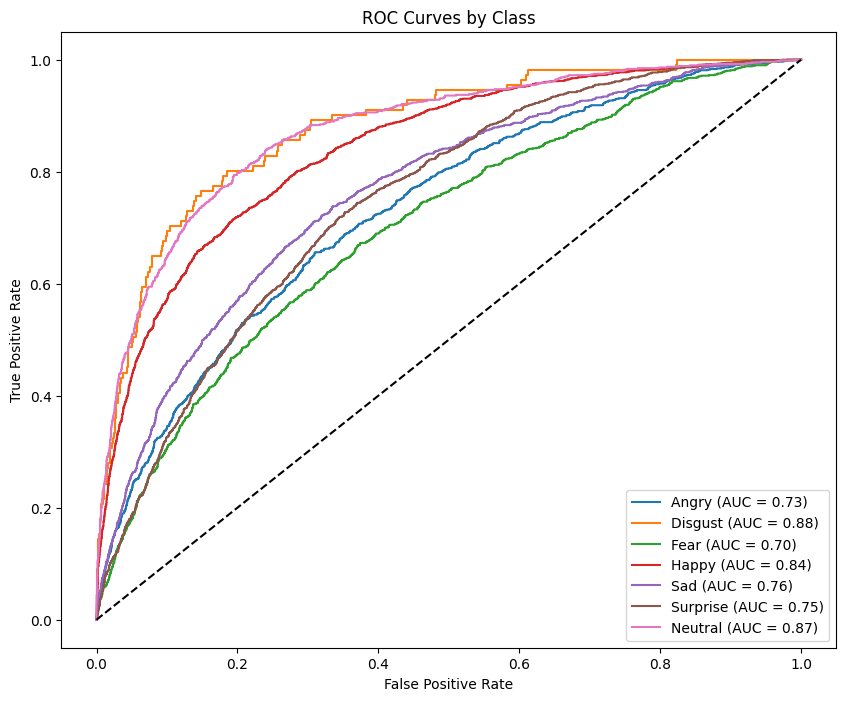

In [56]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

<h2>FINE-TUNING INCEPTION V3:</h2>

In [57]:
# Otvorimo posljednji block za treniranje
fine_tune_epochs = 25
fine_tune_at = 249  # posljednji InceptionV3 block
for layer in inception_base.layers[:fine_tune_at]:
    layer.trainable = False

for layer in inception_base.layers[fine_tune_at:]:
    # Otkljuamo samo slojeve koji imaju trenabilne parametre
    if not isinstance(layer, (tf.keras.layers.BatchNormalization,
                              tf.keras.layers.AveragePooling2D,
                              tf.keras.layers.MaxPooling2D,
                              tf.keras.layers.Concatenate)):
        layer.trainable = True
    else:
        layer.trainable = False


#  Optimizer za fine-tuning (manji LR) 
fine_tune_optimizer = optimizers.Adam(learning_rate=1e-4, amsgrad=True)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Nastavi treniranje (fine-tune) 
history_fine = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluacija 
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# Predikcija 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)


Epoch 66/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 784s 4s/step - accuracy: 0.3558 - auc: 0.7383 - loss: 1.6815 - precision: 0.5545 - recall: 0.1260 - val_accuracy: 0.4180 - val_auc: 0.7882 - val_loss: 1.5349 - val_precision: 0.6418 - val_recall: 0.1848 - learning_rate: 1.0000e-04
Epoch 67/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 712s 3s/step - accuracy: 0.4100 - auc: 0.7821 - loss: 1.5484 - precision: 0.6394 - recall: 0.1696 - val_accuracy: 0.4646 - val_auc: 0.8233 - val_loss: 1.4113 - val_precision: 0.7059 - val_recall: 0.2408 - learning_rate: 1.0000e-04
Epoch 68/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 790s 4s/step - accuracy: 0.4411 - auc: 0.8036 - loss: 1.4783 - precision: 0.6808 - recall: 0.1930 - val_accuracy: 0.4933 - val_auc: 0.8422 - val_loss: 1.3425 - val_precision: 0.7176 - val_recall: 0.2886 - learning_rate: 1.0000e-04
Epoch 69/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 747s 3s/step - accuracy: 0.4604 - auc: 0.8199 - loss: 1.4240 - precision: 0.7002 - recall: 0.2265 - val_accuracy: 0.5083 - val_auc: 0.8542 

In [58]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# Macro and Weighted metrics ---
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class 
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

#  Save everything to file 
with open("inception_finetune_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'inception_finetune_full_report.txt'")

Sve metrike i report su sačuvani u 'inception_finetune_full_report.txt'


In [66]:
with open("inception_finetune_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.1672817468643188, 0.5665156841278076, 0.689180314540863, 0.44622135162353516, 0.8870773315429688]

=== Global metrics ===
Accuracy: 0.5665
Macro Precision: 0.5364
Weighted Precision: 0.5575
Macro Recall: 0.5566
Weighted Recall: 0.5665
Macro F1: 0.5406
Weighted F1: 0.5575
AUC (OVR): 0.8669

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4691    0.4115    0.4384       960
           1     0.4902    0.6757    0.5682       111
           2     0.4679    0.3075    0.3711      1018
           3     0.7204    0.8060    0.7608      1825
           4     0.4902    0.5970    0.5384      1216
           5     0.4585    0.4320    0.4448      1139
           6     0.6588    0.6662    0.6625       797

    accuracy                         0.5665      7066
   macro avg     0.5364    0.5566    0.5406      7066
weighted avg     0.5575    0.5665    0.5575      7066


In [59]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_286              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_287              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,268,734 (214.65 MB)

 Trainable params: 11,395,079 (43.47 MB)

 Non-trainable params: 10,688,416 (40.77 MB)

 Optimizer params: 34,185,239 (130.41 MB)

In [60]:
history_fine.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

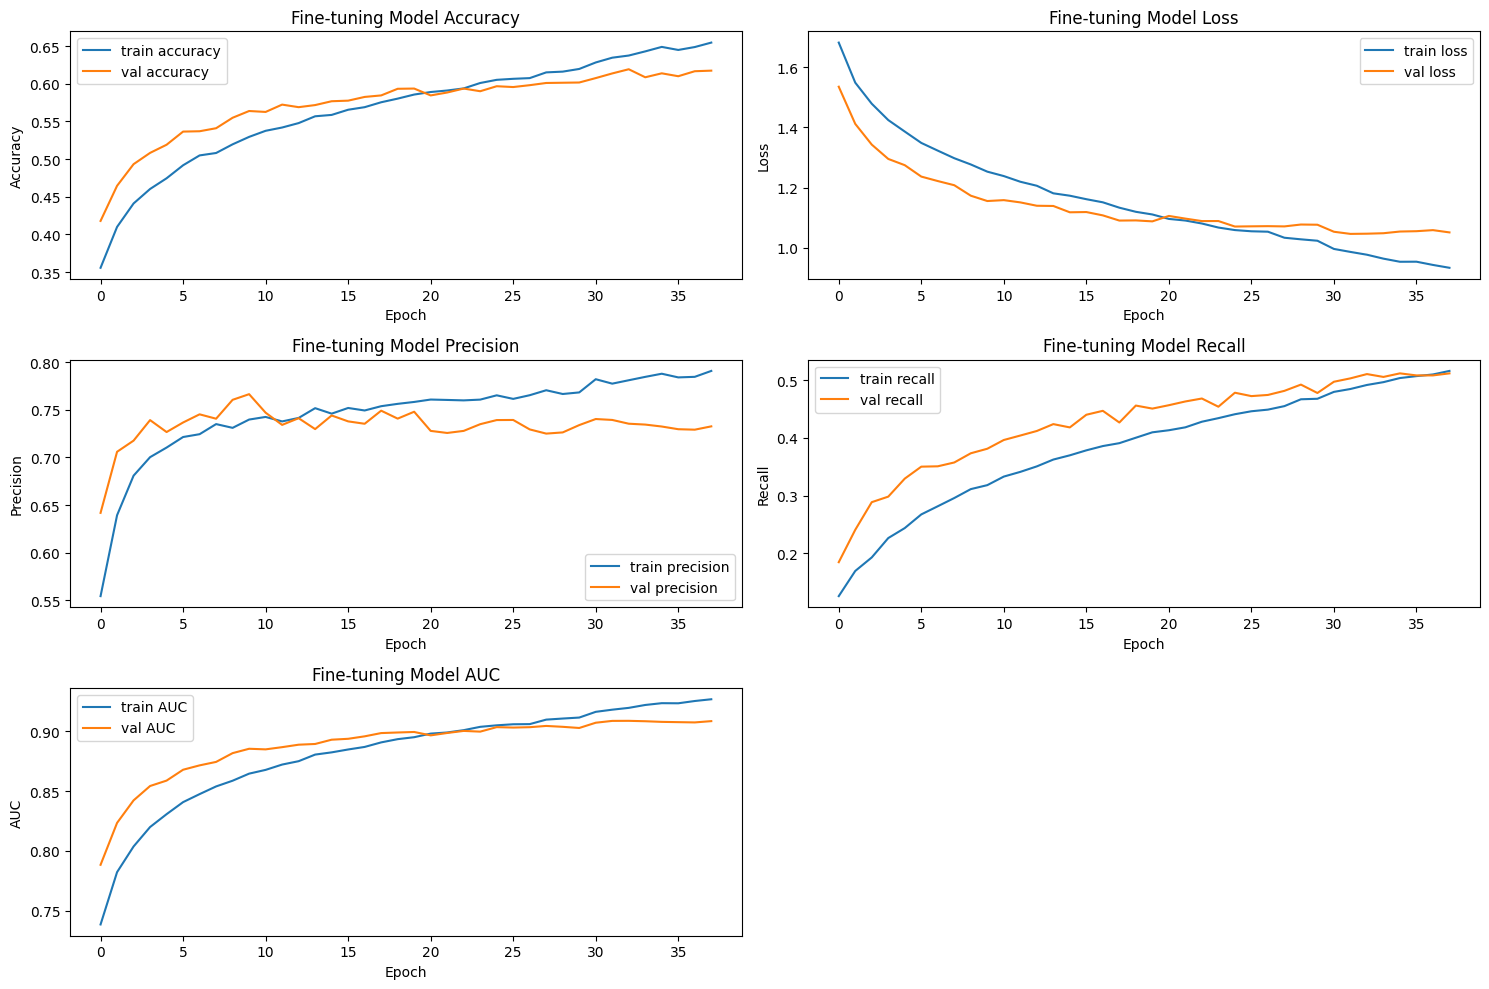

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.title('Fine-tuning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history_fine.history['precision'], label='train precision')
plt.plot(history_fine.history['val_precision'], label='val precision')
plt.title('Fine-tuning Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history_fine.history['recall'], label='train recall')
plt.plot(history_fine.history['val_recall'], label='val recall')
plt.title('Fine-tuning Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history_fine.history['auc'], label='train AUC')
plt.plot(history_fine.history['val_auc'], label='val AUC')
plt.title('Fine-tuning Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


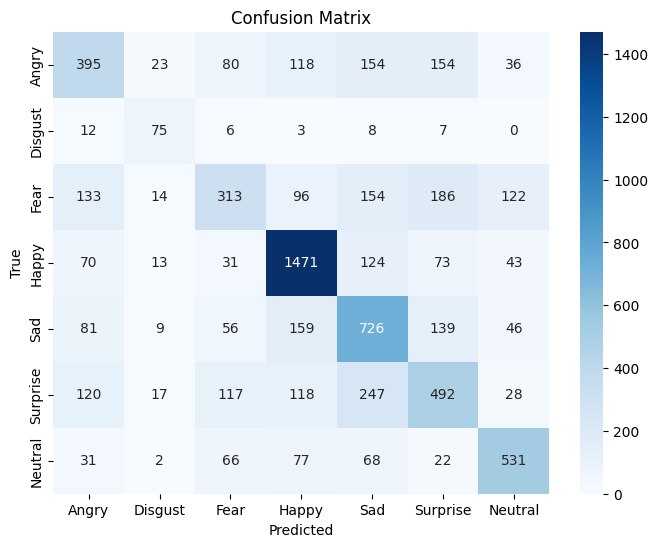

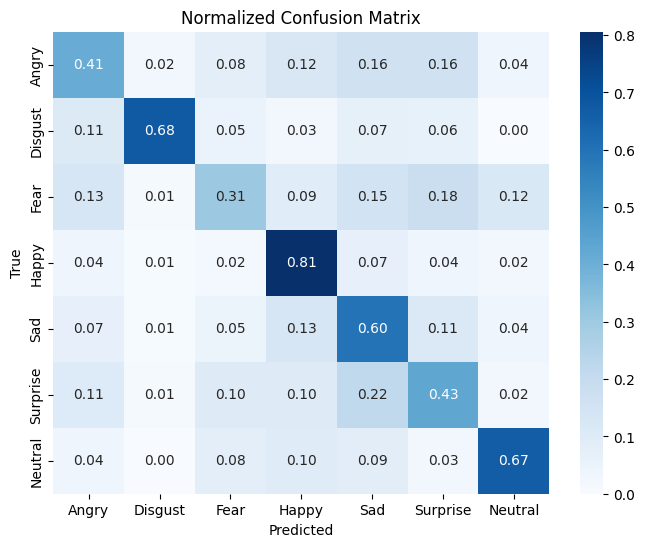

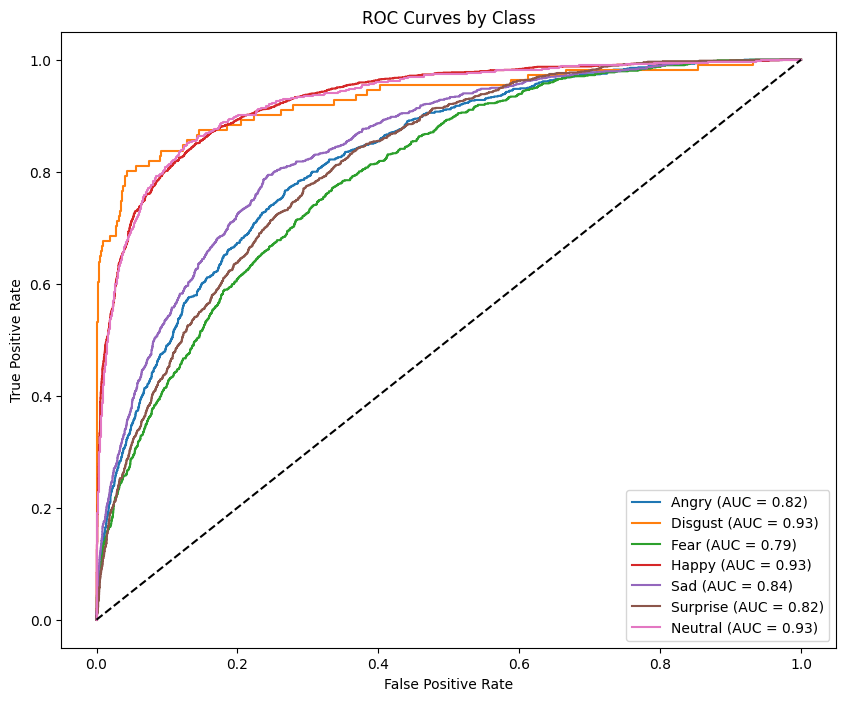

In [62]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

Mreza nema tako dobre rezultate za fear i surprise, iako su podaci ovih klasa balansirani, problem je u slicnim karakteristikama lica za ove 2 emocije. Feature maps mogu biti jako slicni. I zbog malih dimenzija slike, a potom resize-a, model mozda ne vidi dobro jasne detalje.

In [63]:
best_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_286              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_287              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,268,734 (214.65 MB)

 Trainable params: 11,395,079 (43.47 MB)

 Non-trainable params: 10,688,416 (40.77 MB)

 Optimizer params: 34,185,239 (130.41 MB)

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_inception_model.keras')

for i, layer in enumerate(best_model.layers[2].layers):  # [2] jer inception_v3 је treci sloj u modelu
    print(i, layer.name, layer.trainable)


<h3>Prikaz na prvim slikama test seta - Inception V3:</h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

best_model = tf.keras.models.load_model('best_inception_model.keras')

# batch size = 128
for X_batch, y_batch in test_ds_rgb_2.take(1):
    X_test = X_batch.numpy()
    y_test = y_batch.numpy()

# Vizualizacija prvih 36 predikcija
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i]  # (48,48,3)
    
    # Predikcija
    p_dist = best_model.predict(img[np.newaxis, ...])
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img)  # RGB prikaz
    plt.title(f'{emotions[np.argmax(y_test[i])]} - ({emotions[k]} - {p:.4f})', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


<h1 style="color: #16537e">BASELINE CNN</h1>

<h2>RGB:</h2>

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report

img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 5e-4
epochs = 100

# Definisanje naziva klasa
train_class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, model_checkpoint, lr_scheduler]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 74s 325ms/step - accuracy: 0.2458 - auc: 0.6199 - loss: 1.8985 - precision: 0.2696 - recall: 0.0061 - val_accuracy: 0.2212 - val_auc: 0.6308 - val_loss: 1.8867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - accuracy: 0.3206 - auc: 0.6993 - loss: 1.7498 - precision: 0.6153 - recall: 0.0395 - val_accuracy: 0.3102 - val_auc: 0.7199 - val_loss: 1.7818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 315ms/step - accuracy: 0.3630 - auc: 0.7405 - loss: 1.6566 - precision: 0.6651 - recall: 0.0925 - val_accuracy: 0.4331 - val_auc: 0.7984 - val_loss: 1.5507 - val_precision: 0.8650 - val_recall: 0.0871 - learning_rate: 5.0000e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step - accuracy: 0.4028 - auc: 0.7706 - loss: 1.5786 - precision: 0.6909 - recall: 0.1382 - val_accuracy: 0.437

In [34]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# --- Macro and Weighted metrics ---
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# --- Classification report per class ---
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# --- Save everything to file ---
with open("baseline_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'baseline_report.txt'")

Sve metrike i report su sačuvani u 'baseline_report.txt'


In [35]:
with open("baseline_report.txt", "r") as f:
    report_content = f.read()

print(report_content)

=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.0234706401824951, 0.6147750020027161, 0.7587628960609436, 0.46872347593307495, 0.9124701023101807]

=== Global metrics ===
Accuracy: 0.6148
Macro Precision: 0.5768
Weighted Precision: 0.6120
Macro Recall: 0.6061
Weighted Recall: 0.6148
Macro F1: 0.5853
Weighted F1: 0.6103
AUC (OVR): 0.8932

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.5076    0.4885    0.4979       960
           1     0.4706    0.7207    0.5694       111
           2     0.4773    0.3517    0.4050      1018
           3     0.8282    0.8455    0.8368      1825
           4     0.5199    0.6431    0.5750      1216
           5     0.5019    0.4706    0.4857      1139
           6     0.7319    0.7227    0.7273       797

    accuracy                         0.6148      7066
   macro avg     0.5768    0.6061    0.5853      7066
weighted avg     0.6120    0.6148    0.6103      7066

In [36]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,053,335 (7.83 MB)

 Trainable params: 684,359 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,368,720 (5.22 MB)

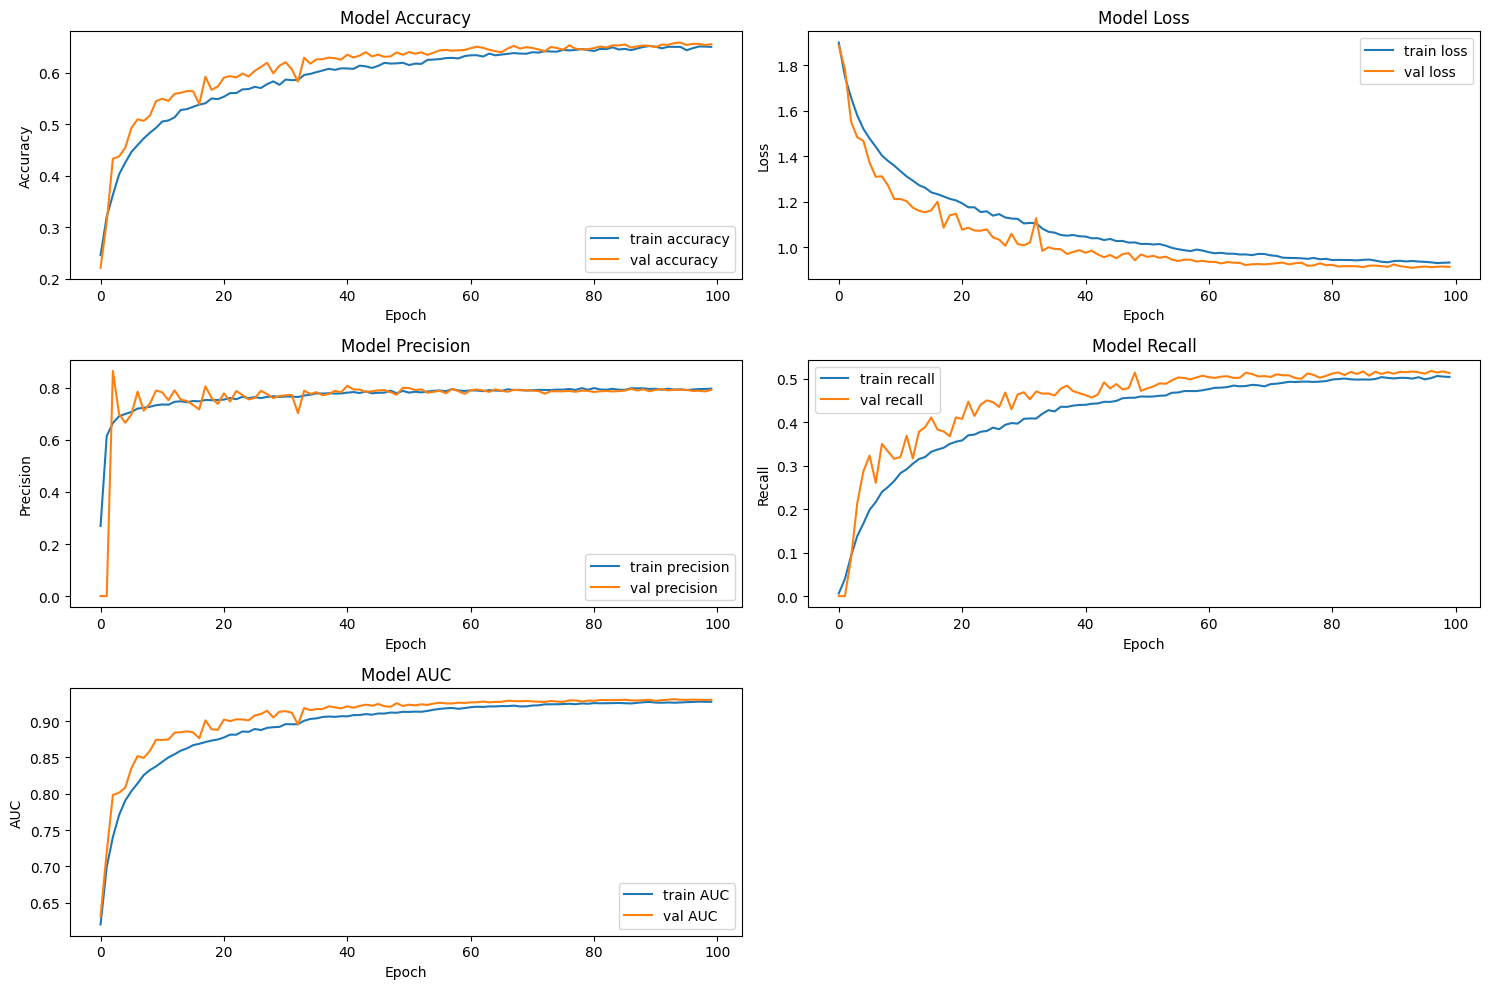

In [37]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

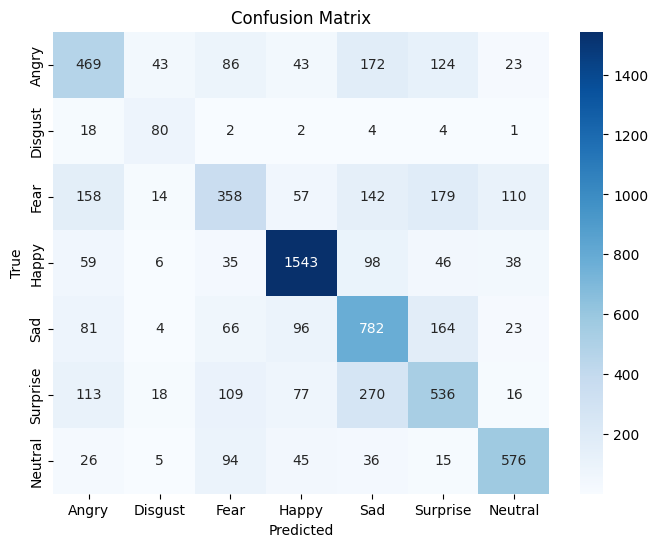

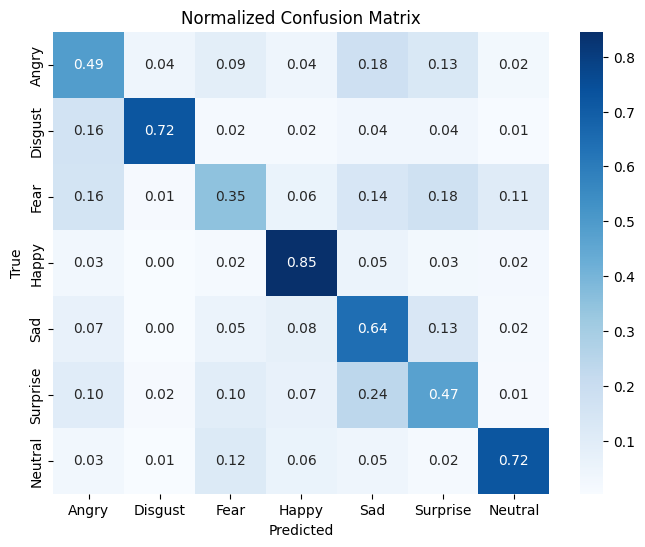

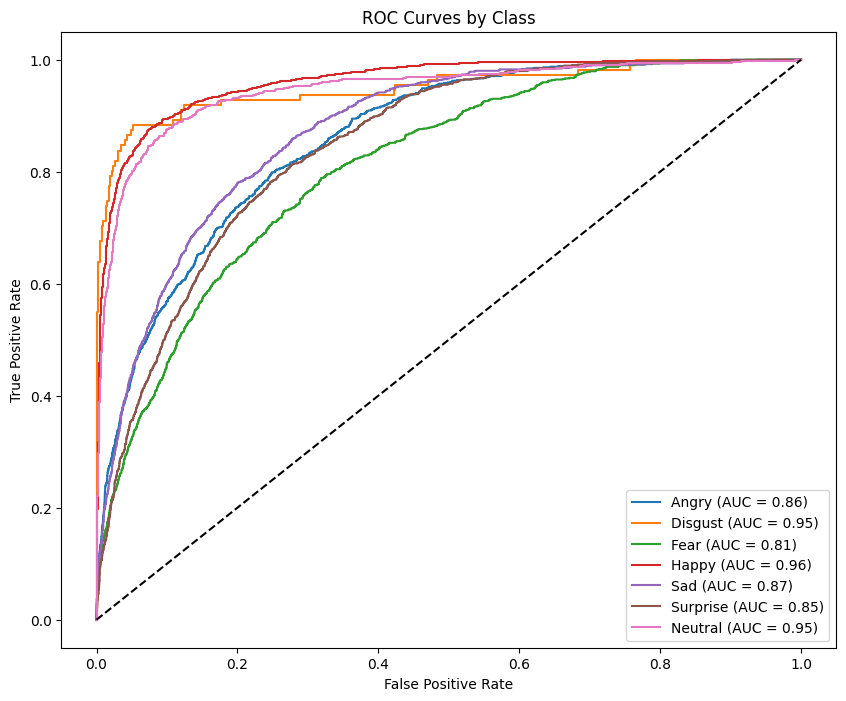

In [38]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.models import load_model
best_model = load_model('best_baseline_cnn.keras')
best_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,053,335 (7.83 MB)

 Trainable params: 684,359 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,368,720 (5.22 MB)

<h3>Prikaz na prvim slikama test seta - baseline RGB:</h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

best_model = tf.keras.models.load_model('best_baseline_cnn.keras')

# batch size = 128
for X_batch, y_batch in test_ds_rgb.take(1):
    X_test = X_batch.numpy()
    y_test = y_batch.numpy()

# Vizualizacija prvih 36 predikcija
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i]  # (48,48,3)
    
    # Predikcija
    p_dist = best_model.predict(img[np.newaxis, ...])
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img)  # RGB prikaz
    plt.title(f'{emotions[np.argmax(y_test[i])]} - ({emotions[k]} - {p:.4f})', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


<h2>GRAYSCALE:</h2>

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report

img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 5e-4
epochs = 100

# Definisanje naziva klasa
train_class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def to_grayscale(image, label):
    # iz [48,48,3] u [48,48,1]
    image = tf.image.rgb_to_grayscale(image)
    return image, label

# Konverzija za train/val/test skupove
train_ds_gray = train_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_gray = val_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gray = test_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

# Build baseline CNN za grayscale
inputs = layers.Input(shape=(img_height, img_width, 1))   # grayscale
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn_gray.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train
history = model.fit(
    train_ds_gray,   
    validation_data=val_ds_gray,
    epochs=epochs,
    callbacks=[early_stop, model_checkpoint, lr_scheduler]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn_gray.keras')
eval_results = best_model.evaluate(test_ds_gray)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_gray], axis=0)
y_pred_prob = best_model.predict(test_ds_gray)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0, target_names=train_class_names))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 66s 287ms/step - accuracy: 0.2342 - auc: 0.6158 - loss: 1.8936 - precision: 0.2284 - recall: 0.0020 - val_accuracy: 0.2212 - val_auc: 0.6232 - val_loss: 1.8914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.3088 - auc: 0.6910 - loss: 1.7669 - precision: 0.6028 - recall: 0.0303 - val_accuracy: 0.2846 - val_auc: 0.7087 - val_loss: 1.8040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 87s 274ms/step - accuracy: 0.3612 - auc: 0.7378 - loss: 1.6637 - precision: 0.6645 - recall: 0.0894 - val_accuracy: 0.4127 - val_auc: 0.7808 - val_loss: 1.5827 - val_precision: 0.8238 - val_recall: 0.0866 - learning_rate: 5.0000e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.4011 - auc: 0.7694 - loss: 1.5806 - precision: 0.6869 - recall: 0.1356 - val_accuracy: 0.456

In [41]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# --- Macro and Weighted metrics ---
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# --- Classification report per class ---
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# --- Save everything to file ---
with open("baseline_gray_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'baseline_gray_report.txt'")

Sve metrike i report su sačuvani u 'baseline_gray_report.txt'


In [42]:
with open("baseline_gray_report.txt", "r") as f:
    report_content = f.read()

print(report_content)

=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.029132604598999, 0.6164732575416565, 0.7502252459526062, 0.47141239047050476, 0.91164630651474]

=== Global metrics ===
Accuracy: 0.6165
Macro Precision: 0.5984
Weighted Precision: 0.6175
Macro Recall: 0.6082
Weighted Recall: 0.6165
Macro F1: 0.6000
Weighted F1: 0.6140
AUC (OVR): 0.8917

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4995    0.5115    0.5054       960
           1     0.6031    0.7117    0.6529       111
           2     0.4867    0.3585    0.4129      1018
           3     0.8425    0.8323    0.8374      1825
           4     0.5045    0.6447    0.5661      1216
           5     0.5037    0.4759    0.4894      1139
           6     0.7490    0.7227    0.7356       797

    accuracy                         0.6165      7066
   macro avg     0.5984    0.6082    0.6000      7066
weighted avg     0.6175    0.6165    0.6140      7066



In [43]:
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,607 (7.83 MB)

 Trainable params: 683,783 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,367,568 (5.22 MB)

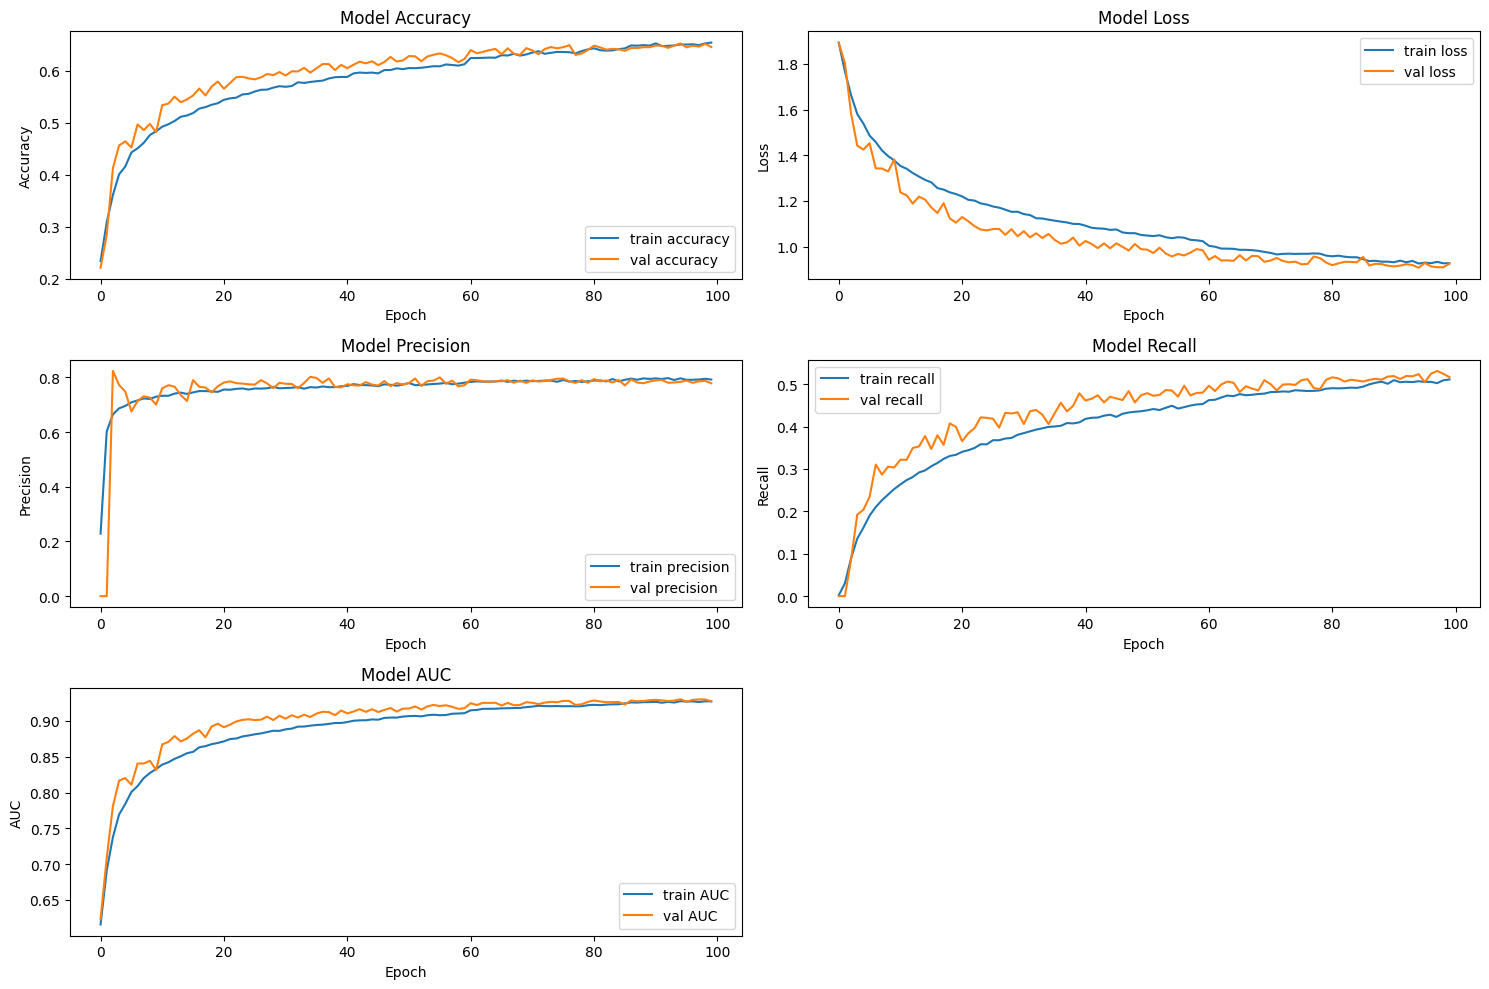

In [44]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

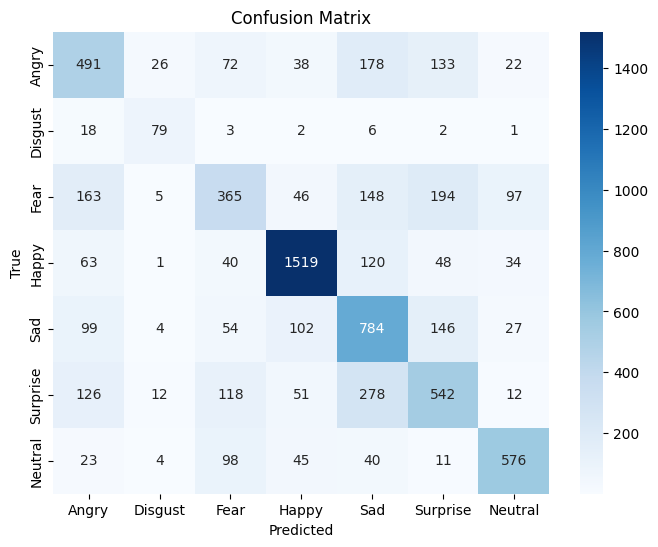

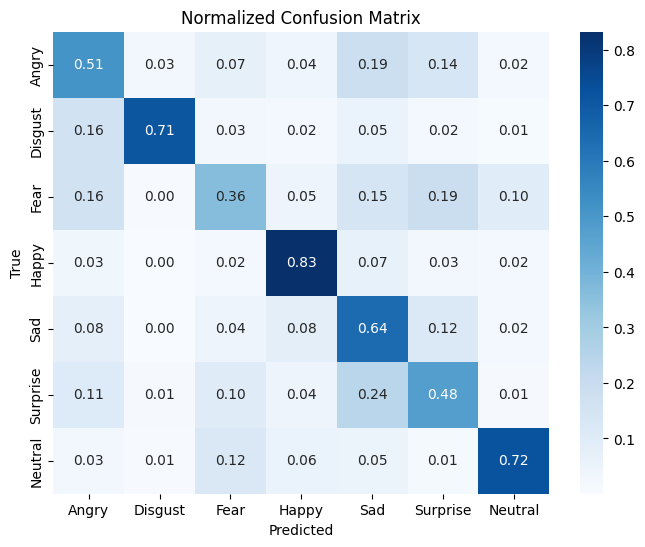

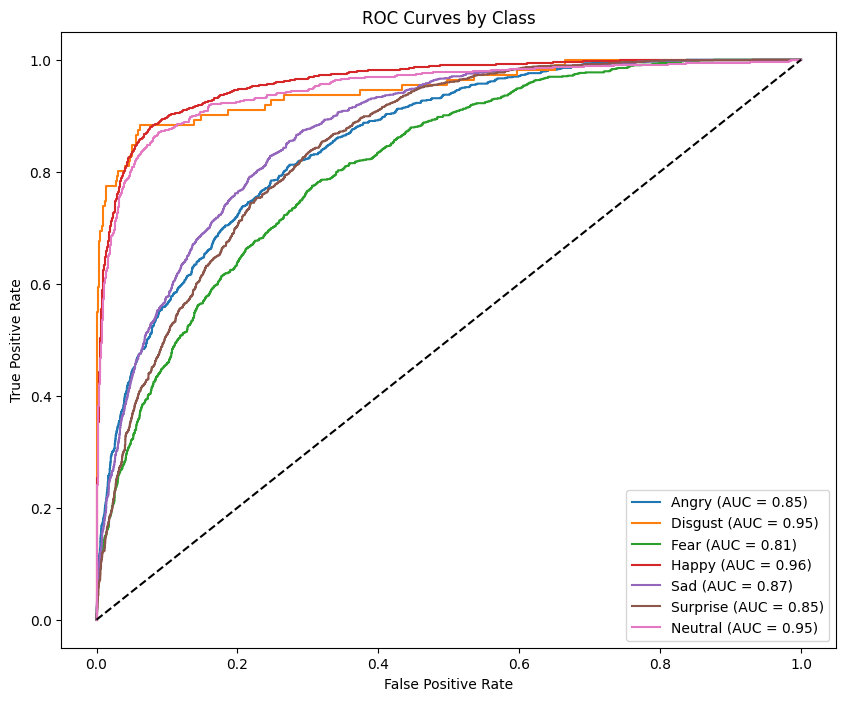

In [45]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [46]:
from tensorflow.keras.models import load_model
best_model = load_model('best_baseline_cnn_gray.keras')
best_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,607 (7.83 MB)

 Trainable params: 683,783 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,367,568 (5.22 MB)